<a href="https://colab.research.google.com/github/WANGOMES/transfer-learning-project-with-python/blob/main/Transfer_learning_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer learning project with Python**
O Modelo Xception foi utilizado para classificação "gatos vs. cães" do Kaggle. Xception é um modelo pré-treinado para reconhecimento de imagens.

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
tfds.disable_progress_bar()

treino, validacao, teste = tfds.load(
    "cats_vs_dogs", 
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"], 
    as_supervised=True)

print("Nº amostras para TREINO: %d" % tf.data.experimental.cardinality(treino))
print("Nº amostras para VALIDAÇÃO: %d" % tf.data.experimental.cardinality(validacao))
print("Nº amostras para TESTE: %d" % tf.data.experimental.cardinality(teste))

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Nº amostras para TREINO: 9305
Nº amostras para VALIDAÇÃO: 2326
Nº amostras para TESTE: 2326


In [4]:
import matplotlib.pyplot as plt

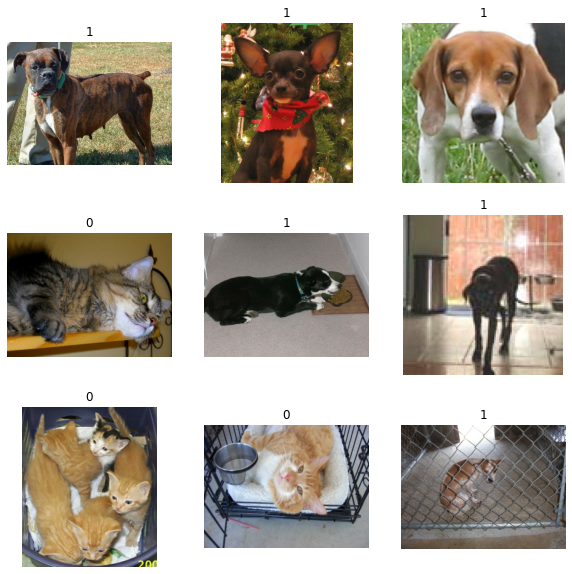

In [5]:
plt.figure(figsize=(10, 10))
for i, (imagem, etiqueta) in enumerate(treino.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(imagem)
  plt.title(int(etiqueta))
  plt.axis("off")

# **Padronizando dos dados**
Padronizar o tamanho das imagens e normalizar os valores de pixel.

In [6]:
size = (150, 150)

treino = treino.map(lambda x, y:(tf.image.resize(x, size), y))
teste = teste.map(lambda x, y:(tf.image.resize(x, size), y))
validacao = validacao.map(lambda x, y:(tf.image.resize(x, size), y))

# **Aumentando o dataset de treino**
Para evitar o overfitting aumentaremos o conjunto de dados utilizando transformações aleatórias às imagens de treinamento. O overfitting acontece quando os resultados do treino são excelentes, enquanto os do teste é ruins.

In [7]:
batch_size = 32

treino = treino.cache().batch(batch_size).prefetch(buffer_size=10)
validacao = validacao.cache().batch(batch_size).prefetch(buffer_size=10)
teste = teste.cache().batch(batch_size).prefetch(buffer_size=10)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),       # Invertendo as imagens horizontalmente
     layers.RandomRotation(0.1),]           # Rotacionado as imagens aleatoriamente
)

In [10]:
import numpy as np

**Visualizando a primeira imagem com as transformações aplicadas**

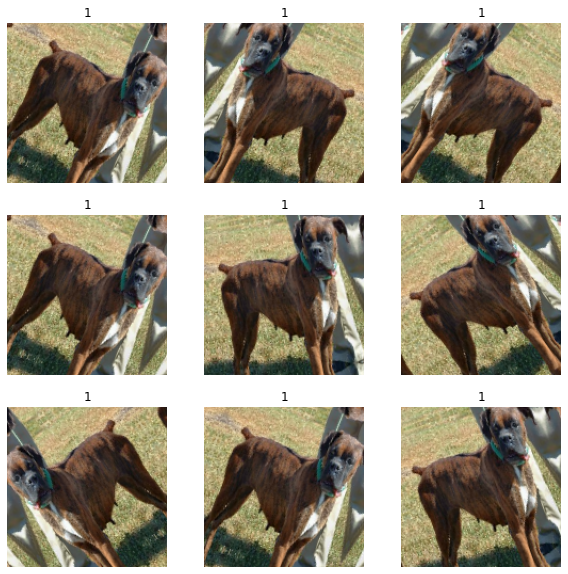

In [11]:
for imagens, etiquetas in treino.take(1):
  plt.figure(figsize=(10, 10))
  imagem1 = imagens[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(
        tf.expand_dims(imagem1, 0), training=True
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.title(int(etiquetas[0]))
    plt.axis("off")

# **Construindo modelo**

In [12]:
modelo_base = keras.applications.Xception(
    weights="imagenet",                      # Carregando os pesos pré treinados na ImageNet dataset.
    input_shape=(150, 150, 3),
    include_top=False,                       # Não inclua o classificador ImageNet no topo.
)

# Congelando o modelo_base
modelo_base.trainable = False

# Criando novo modelo no top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)                # Aplicando data augmentation aleatório.

# Os pesos Xception pré-treinados exigem que a entrada seja dimensionada
# de (0, 255) a um intervalo de (-1., +1.), a camada de reescalonamento
# outputs: `(inputs * scale) + offset`

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# O modelo_base contém camadas de norma de lote. Queremos mantê-los no modo de inferência
# quando descongelamos o modelo_base para fine-tuning, então nos certificamos de que o
# modelo_base está sendo executado no modo de inferência aqui.
x = modelo_base(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
modelo = keras.Model(inputs, outputs)

modelo.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

# **Treinando a Camada do Topo**

In [ ]:
modelo.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epocas = 20
modelo.fit(treino, epochs=epocas, validation_data=validacao)

Epoch 1/20
291/291 [==============================] - 1058s 4s/step - loss: 0.1709 - binary_accuracy: 0.9238 - val_loss: 0.0842 - val_binary_accuracy: 0.9686
Epoch 2/20
291/291 [==============================] - 1031s 4s/step - loss: 0.1192 - binary_accuracy: 0.9501 - val_loss: 0.0770 - val_binary_accuracy: 0.9708
Epoch 3/20
291/291 [==============================] - 1023s 4s/step - loss: 0.1109 - binary_accuracy: 0.9534 - val_loss: 0.0755 - val_binary_accuracy: 0.9695
Epoch 4/20
291/291 [==============================] - 1030s 4s/step - loss: 0.1135 - binary_accuracy: 0.9513 - val_loss: 0.0744 - val_binary_accuracy: 0.9690
Epoch 5/20
291/291 [==============================] - 1018s 4s/step - loss: 0.1054 - binary_accuracy: 0.9551 - val_loss: 0.0728 - val_binary_accuracy: 0.9712
Epoch 6/20
291/291 [==============================] - 1019s 4s/step - loss: 0.1046 - binary_accuracy: 0.9575 - val_loss: 0.0739 - val_binary_accuracy: 0.9716
Epoch 7/20
291/291 [==============================] 

# **Fazendo o fine-tuning**
Ao descongelar o modelo_base treinaremos o modelo do inicio ao fim com baixa taxa de aprendizado.

In [ ]:
modelo_base.trainable = True
modelo.summary()

modelo.compile(
    optimizer=keras.optimizers.Adam(1e-5),                     # Baixa taxa de aprendizado.
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epocas = 10
modelo.fit(treino, epochs=epocas, validation_data=validacao)